In [1]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math
import pickle

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [23]:
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_dict={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

def visualize_embedding(features, labels, label_dict=None, save_path=None):
    if label_dict is None:
        str_labels = labels
    else:
        str_labels = [label_dict[k] for k in labels]

    tsne_features = TSNE(n_components=2).fit_transform(features)
    fig, ax = plt.subplots(figsize=(15,10))
    sns.scatterplot(ax=ax, x=tsne_features[:,0], y=tsne_features[:,1], 
                    hue=str_labels, style=str_labels, palette="deep")

    if save_path is not None:
        fig.savefig(save_path)

    return fig, tsne_features


def visualize_cm(cm, save_path=None, str_labels=None):
    
    fig, ax = plt.subplots(figsize=(15,10))
    xticklabels = str_labels if str_labels is not None else 'auto'
    yticklabels = str_labels if str_labels is not None else 'auto'
    sns.heatmap(cm, vmin=0, vmax=1, ax=ax, annot=True, xticklabels=xticklabels, yticklabels=yticklabels)

    if save_path is not None:
        fig.savefig(save_path)

    return fig

## Data loader

In [2]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
#         X = X.split()
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(48,48)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(image=X)['image']

#             X = torch.cat((X,X,X),0)

        return X, y

In [43]:
batch_size= 256

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']


train_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(48,48),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, p=0.5, border_mode=0, value=0),
#     A.RandomCrop(height=40, width=40),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])


test_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(48,48),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])

# train_set = FERDataset(df_train, train_transforms)
train_set = FERDataset(df_train, test_transforms) # no augmentation!
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Center loss

In [6]:
class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.cuda()
            
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

In [29]:
a = torch.rand(12, 256).sum(dim=1, keepdims=True).expand(12, 7)
a.size()

torch.Size([12, 7])

## Exploss

In [7]:
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        mask = self.filter_mask(labels)
        att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
#         att = self.att_act(sims)
#         print('att after sigmoid: ', att.min(), att.max(), att.mean(), att.var())
        
#         print('att pure: ', sims.min(), sims.max(), sims.mean(), sims.var())
#         att = torch.tanh(sims)
#         print('att after tanh: ', att.min(), att.max(), att.mean(), att.var())
#         att = self.relu(att)
#         print('att after relu: ', att.min(), att.max(), att.mean(), att.var())
# #         print('min: %.4f, max: %.4f, var: %.4f' % (att.min(), att.max(), att.std()))
        
#         x = self.main_fc(x)
        x = torch.mm(att, x)
#         print('x before out_fc: ', x.min(), x.max(), x.mean(), x.var())
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
    
#         print('x after out_fc: ', x.min(), x.max(), x.mean(), x.var())
        
#         print('att: ', att.min(), att.max(), att.mean(), att.var())
        
        
#         # cal sims loss
#         mask = self.filter_mask(labels)
#         sims = sims * mask.to(sims.device)


#         # prevent negative value
#         sims = self.sim_act(sims)
        
#         sims = sims.sum()
#         sims = sims / self.depth
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

## sVGG

In [12]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes, residual=True, use_centerloss=False, use_gpu=True):
        super(sVGG_exp, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.exploss = ExpLoss(512, residual=residual)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
        self.centerloss = CenterLoss(num_classes=n_classes, feat_dim=in_features_classifier, use_gpu=use_gpu) if use_centerloss is True else None
        
    def forward(self, x, labels, return_att=True):
        x = self.features(x)
        att, sim_loss = self.exploss(x, labels)
        att = self.flatten(att)
        
        centloss = 0.
        if self.centerloss:
            centloss = self.centerloss(att, labels)

#         att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, centloss, att
        return x, centloss
        

In [15]:
from torchvision.models import vgg16_bn

# create model
device = torch.device('cuda')
lr = 0.001
model = sVGG_exp(features=vgg16_bn(pretrained=False).features[:34], in_features_classifier=512, n_classes=7, residual=True, use_centerloss=True, use_gpu=True)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)


In [16]:
alpha = 1
model_path = 'exploss_centerloss/resExploss_sVGG_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, centloss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + (alpha*centloss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, centloss, features = model(inputs, labels)

        loss = criterion(outputs, labels) + (alpha*centloss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        if model_path is not None:
            torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
Loss=259.1367492675781 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:19<00:00, 22.96it/s]

- Avg.loss: 470.9989 | Avg.acc: 0.3957



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 272.2821 | Avg. test_acc: 0.3681
* Update optimal model
Epoch:  2


Loss=119.12489318847656 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 22.90it/s]

- Avg.loss: 176.7308 | Avg.acc: 0.5829


- Avg. test_loss: 139.5001 | Avg. test_acc: 0.4773


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=59.18711471557617 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 22.91it/s]

- Avg.loss: 81.2902 | Avg.acc: 0.7535


- Avg. test_loss: 86.9296 | Avg. test_acc: 0.6737


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=32.13718795776367 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.85it/s]

- Avg.loss: 41.2528 | Avg.acc: 0.8036



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 41.6415 | Avg. test_acc: 0.6269
Epoch:  5


Loss=19.289888381958008 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:19<00:00, 22.83it/s]

- Avg.loss: 21.6995 | Avg.acc: 0.8318


- Avg. test_loss: 30.0249 | Avg. test_acc: 0.7570


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=9.639813423156738 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.77it/s]

- Avg.loss: 11.4379 | Avg.acc: 0.8423


- Avg. test_loss: 18.4083 | Avg. test_acc: 0.7618


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=4.913506984710693 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 22.84it/s]

- Avg.loss: 6.6020 | Avg.acc: 0.8558


- Avg. test_loss: 28.7150 | Avg. test_acc: 0.8189


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=9.377439498901367 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 22.81it/s]

- Avg.loss: 3.9191 | Avg.acc: 0.8695



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 12.7493 | Avg. test_acc: 0.7640
Epoch:  9


Loss=2.655653238296509 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 22.79it/s]

- Avg.loss: 2.5989 | Avg.acc: 0.8796


- Avg. test_loss: 12.4286 | Avg. test_acc: 0.8345


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.4142072200775146 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.73it/s]

- Avg.loss: 1.9276 | Avg.acc: 0.8908



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 8.7628 | Avg. test_acc: 0.8130
Epoch:  11


Loss=10.464102745056152 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 22.81it/s]

- Avg.loss: 1.6182 | Avg.acc: 0.8996


- Avg. test_loss: 30.7036 | Avg. test_acc: 0.8512


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=3.5597076416015625 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 22.76it/s]

- Avg.loss: 1.4587 | Avg.acc: 0.8876



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 7.2161 | Avg. test_acc: 0.8345
Epoch:  13


Loss=1.353874921798706 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.67it/s]

- Avg.loss: 1.2721 | Avg.acc: 0.9012



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 6.1825 | Avg. test_acc: 0.8351
Epoch:  14


Loss=1.1131744384765625 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 22.74it/s]

- Avg.loss: 1.0168 | Avg.acc: 0.9172



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 6.9071 | Avg. test_acc: 0.6662
Epoch:  15


Loss=2.281489849090576 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 22.76it/s]

- Avg.loss: 0.8410 | Avg.acc: 0.9295



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 7.2285 | Avg. test_acc: 0.7771
Epoch:  16


Loss=2.5374958515167236 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 22.72it/s]

- Avg.loss: 0.8507 | Avg.acc: 0.9193



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 11.7078 | Avg. test_acc: 0.5508
Epoch:  17


Loss=1.0548526048660278 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 22.74it/s]

- Avg.loss: 0.8877 | Avg.acc: 0.9161



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 5.6052 | Avg. test_acc: 0.7855
Epoch    17: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  18


Loss=1.0512539148330688 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.74it/s]

- Avg.loss: 0.5646 | Avg.acc: 0.9538


- Avg. test_loss: 4.4962 | Avg. test_acc: 0.8805


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=0.345946729183197 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.66it/s]

- Avg.loss: 0.4880 | Avg.acc: 0.9619



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.8556 | Avg. test_acc: 0.8802
Epoch:  20


Loss=2.317750930786133 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 22.70it/s]

- Avg.loss: 0.4651 | Avg.acc: 0.9693


- Avg. test_loss: 3.6056 | Avg. test_acc: 0.8835


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=0.38370293378829956 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.71it/s]

- Avg.loss: 0.4478 | Avg.acc: 0.9678


- Avg. test_loss: 3.6345 | Avg. test_acc: 0.8975


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  22


Loss=0.35968416929244995 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 22.70it/s]

- Avg.loss: 0.4706 | Avg.acc: 0.9687



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.8456 | Avg. test_acc: 0.8431
Epoch:  23


Loss=0.9867776036262512 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 22.71it/s]

- Avg.loss: 0.3946 | Avg.acc: 0.9734


- Avg. test_loss: 3.7591 | Avg. test_acc: 0.9036


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  24


Loss=0.3916119933128357 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.67it/s]      

- Avg.loss: 0.3691 | Avg.acc: 0.9740



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.2170 | Avg. test_acc: 0.8757
Epoch:  25


Loss=14.130830764770508 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:19<00:00, 22.70it/s]

- Avg.loss: 0.4517 | Avg.acc: 0.9650


- Avg. test_loss: 4.5586 | Avg. test_acc: 0.9111


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  26


Loss=0.3098744750022888 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.68it/s]      

- Avg.loss: 0.3817 | Avg.acc: 0.9712



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.6068 | Avg. test_acc: 0.8989
Epoch:  27


Loss=2.405738353729248 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.65it/s]

- Avg.loss: 0.3430 | Avg.acc: 0.9786



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.6691 | Avg. test_acc: 0.8573
Epoch:  28


Loss=0.7421365976333618 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.67it/s]      

- Avg.loss: 0.3558 | Avg.acc: 0.9746



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 4.8529 | Avg. test_acc: 0.8952
Epoch:  29


Loss=0.26567715406417847 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.67it/s]     

- Avg.loss: 0.3369 | Avg.acc: 0.9788



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.3881 | Avg. test_acc: 0.8660
Epoch:  30


Loss=0.3207569420337677 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.66it/s]

- Avg.loss: 0.3529 | Avg.acc: 0.9770



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 5.4379 | Avg. test_acc: 0.9000
Epoch:  31


Loss=0.4066193699836731 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.71it/s]

- Avg.loss: 0.3465 | Avg.acc: 0.9785



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.5679 | Avg. test_acc: 0.8897
Epoch    31: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  32


Loss=0.9737611413002014 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.62it/s]

- Avg.loss: 0.3084 | Avg.acc: 0.9777



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.7783 | Avg. test_acc: 0.8888
Epoch:  33


Loss=0.17026150226593018 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.70it/s]     

- Avg.loss: 0.2968 | Avg.acc: 0.9808



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.2399 | Avg. test_acc: 0.8919
Epoch:  34


Loss=0.8703020811080933 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.58it/s]

- Avg.loss: 0.2936 | Avg.acc: 0.9806



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.7729 | Avg. test_acc: 0.8983
Epoch:  35


Loss=0.3713299632072449 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 22.70it/s]

- Avg.loss: 0.2881 | Avg.acc: 0.9838


- Avg. test_loss: 4.4445 | Avg. test_acc: 0.9117


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  36


Loss=1.832322120666504 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 22.64it/s]

- Avg.loss: 0.2782 | Avg.acc: 0.9828


- Avg. test_loss: 4.4044 | Avg. test_acc: 0.9125


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  37


Loss=0.17664030194282532 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.58it/s]     

- Avg.loss: 0.3027 | Avg.acc: 0.9835


- Avg. test_loss: 3.5596 | Avg. test_acc: 0.9145


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  38


Loss=0.1936095654964447 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.63it/s]      

- Avg.loss: 0.2676 | Avg.acc: 0.9835



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.3452 | Avg. test_acc: 0.8924
Epoch:  39


Loss=0.22467608749866486 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.67it/s]     

- Avg.loss: 0.2793 | Avg.acc: 0.9821



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.2971 | Avg. test_acc: 0.9069
Epoch:  40


Loss=1.096388339996338 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 22.68it/s]

- Avg.loss: 0.2637 | Avg.acc: 0.9861


- Avg. test_loss: 3.6110 | Avg. test_acc: 0.9315


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  41


Loss=0.2606002688407898 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 22.70it/s]

- Avg.loss: 0.2426 | Avg.acc: 0.9848



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.3846 | Avg. test_acc: 0.9114
Epoch:  42


Loss=1.7528847455978394 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.66it/s]      

- Avg.loss: 0.2790 | Avg.acc: 0.9844



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.8961 | Avg. test_acc: 0.8885
Epoch:  43


Loss=0.1339385062456131 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.65it/s]      

- Avg.loss: 0.2717 | Avg.acc: 0.9863



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.8571 | Avg. test_acc: 0.8813
Epoch:  44


Loss=0.06821483373641968 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.70it/s]     

- Avg.loss: 0.2810 | Avg.acc: 0.9817



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.9052 | Avg. test_acc: 0.8983
Epoch:  45


Loss=0.271122545003891 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.66it/s]

- Avg.loss: 0.2513 | Avg.acc: 0.9839



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.2511 | Avg. test_acc: 0.9075
Epoch:  46


Loss=0.4557546079158783 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.62it/s]      

- Avg.loss: 0.2783 | Avg.acc: 0.9816



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.4277 | Avg. test_acc: 0.9036
Epoch    46: reducing learning rate of group 0 to 1.0000e-06.
Epoch:  47


Loss=1.4008376598358154 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.63it/s]      

- Avg.loss: 0.2401 | Avg.acc: 0.9863



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.6513 | Avg. test_acc: 0.8919
Epoch:  48


Loss=0.08711106330156326 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.64it/s]     

- Avg.loss: 0.2371 | Avg.acc: 0.9889



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.9415 | Avg. test_acc: 0.8966
Epoch:  49


Loss=0.49352025985717773 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.59it/s]

- Avg.loss: 0.2623 | Avg.acc: 0.9869



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.7895 | Avg. test_acc: 0.8972
Epoch:  50


Loss=0.22924762964248657 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.67it/s]     

- Avg.loss: 0.2446 | Avg.acc: 0.9856


- Avg. test_loss: 4.2972 | Avg. test_acc: 0.8933


In [17]:
pickle.dump(hist, open('exploss_centerloss/resExploss_sVGG_hist.hdf5', 'wb'))

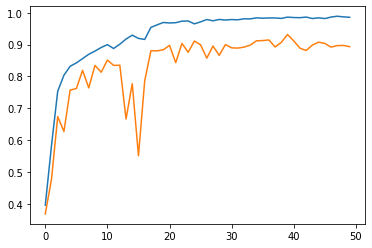

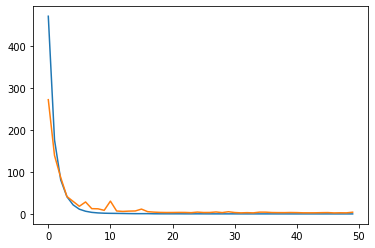

(0.9314572304263026, 3.6109834545068535)

In [18]:
plt.plot([k[-2] for k in hist])
plt.plot([k[-1] for k in hist])
plt.show()
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])
plt.show()

best_acc, curloss

#### Test with batch size 64

In [21]:
model = torch.load('exploss_centerloss/resExploss_sVGG_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,centloss, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels) + (alpha*centloss)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 3.6110 | Avg. val_acc: 0.9315


#### Test with batch size 32

In [39]:
model = torch.load('exploss_centerloss/resExploss_sVGG_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,centloss, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels) + (alpha*centloss)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 7.8664 | Avg. val_acc: 0.8448


#### Test with batch size 256

In [44]:
model = torch.load('exploss_centerloss/resExploss_sVGG_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,centloss, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels) + (alpha*centloss)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 0.9379 | Avg. val_acc: 0.9994


In [45]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>, array([[ 29.623041 , -37.05651  ],
        [ 18.479815 ,  -4.460435 ],
        [-65.33395  ,  17.134007 ],
        ...,
        [-68.21064  ,   3.3952992],
        [-43.98889  , -48.707283 ],
        [  3.4020548,  54.826244 ]], dtype=float32))

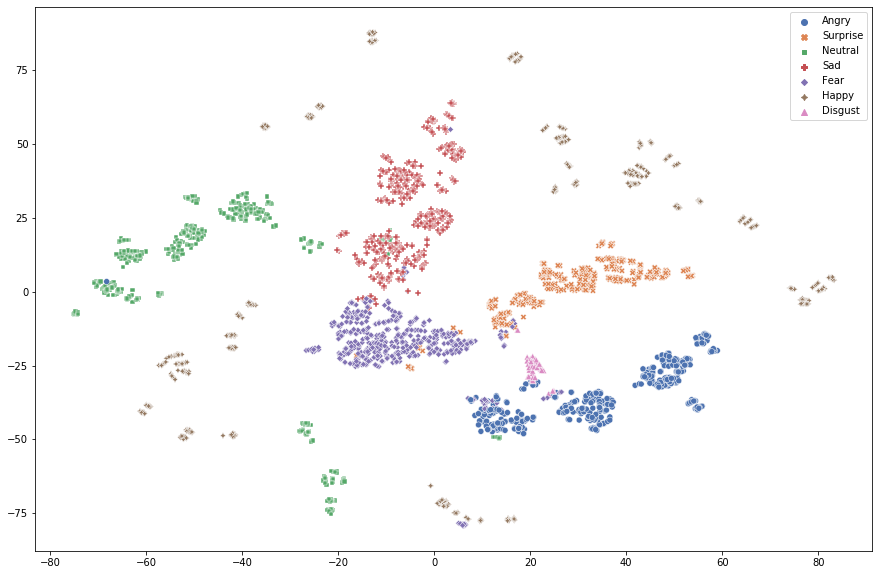

In [25]:
# batch size 64
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path='exploss_centerloss/resExploss_sVGG_tsne.png')


(<Figure size 1080x720 with 1 Axes>, array([[ 52.369286  ,  -0.61743855],
        [-23.973001  ,  59.18801   ],
        [-35.49163   ,  -9.826305  ],
        ...,
        [-21.841692  , -25.345053  ],
        [ 27.53595   , -47.941433  ],
        [ 50.140537  ,  38.909576  ]], dtype=float32))

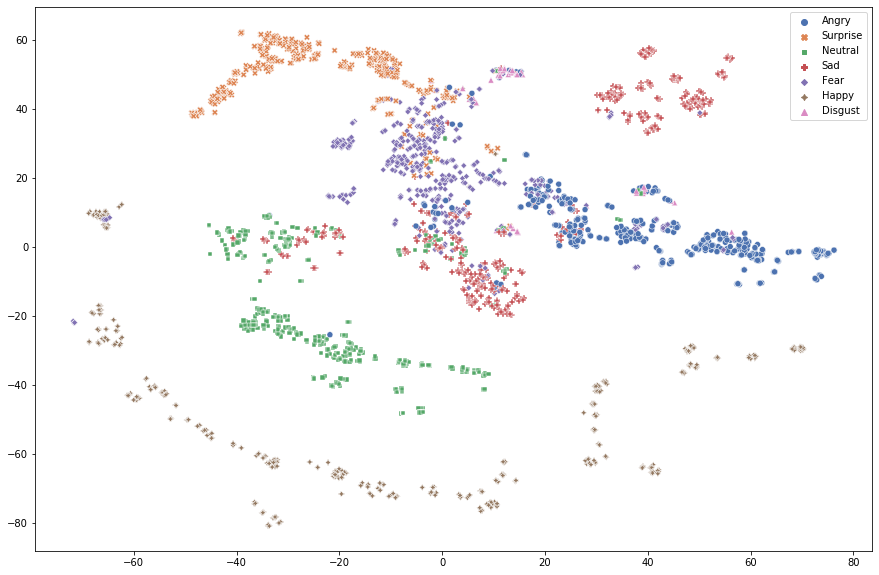

In [42]:
# batch size 32
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)


(<Figure size 1080x720 with 1 Axes>, array([[ 48.509354,   7.367981],
        [-36.284447,  29.928974],
        [  9.245486, -47.58381 ],
        ...,
        [ 32.26868 , -34.937004],
        [ -8.203411, -74.71798 ],
        [-41.84463 , -51.449505]], dtype=float32))

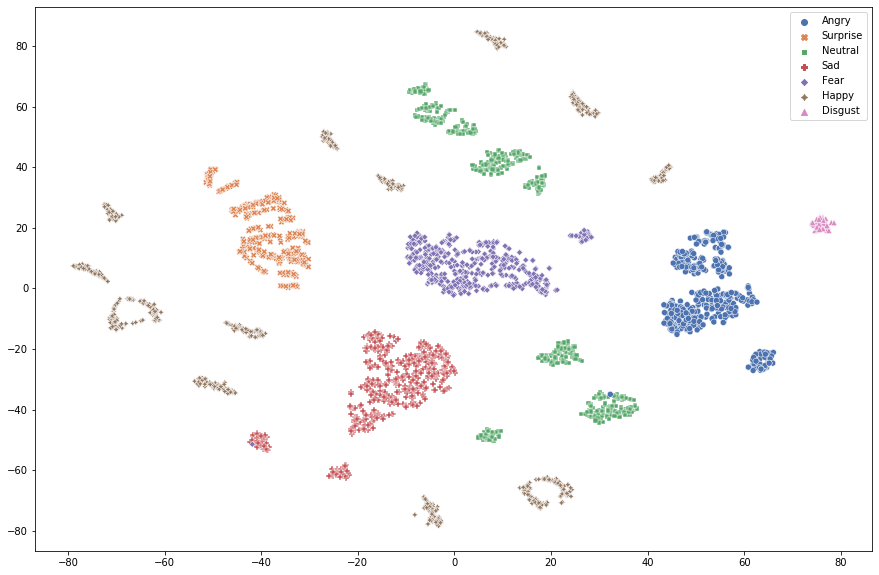

In [46]:
# batch size 256
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)
